<a href="https://colab.research.google.com/github/ChanceDurr/DS-Unit-2-Applied-Modeling/blob/master/module3-hyperparamter-optimization/Chance_Dare_hyper_param.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and csv's

In [2]:
import pandas as pd
from glob import glob
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
# !pip install category_encoders
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor

     |████████████████████████████████| 92kB 5.7MB/s 


In [3]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip

--2019-07-24 20:40:16--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823789 (804K) [application/zip]
Saving to: ‘caterpillar-tube-pricing.zip’

caterpillar-tube-pr 100%[===================>] 804.48K  --.-KB/s    in 0.04s   

2019-07-24 20:40:16 (18.6 MB/s) - ‘caterpillar-tube-pricing.zip’ saved [823789/823789]



In [4]:
!unzip caterpillar-tube-pricing.zip

Archive:  caterpillar-tube-pricing.zip
  inflating: sample_submission.csv   
  inflating: data.zip                


In [5]:
!unzip data.zip

Archive:  data.zip
   creating: competition_data/
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv  
  inflating: competition_data/type_connection.csv  
  i

In [0]:
def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [7]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/test_set.csv (30235, 8)
competition_data/comp_adaptor.csv (25, 20)
competition_data/comp_elbow.csv (178, 16)
competition_data/train_set.csv (30213, 8)
competition_data/comp_other.csv (1001, 3)
competition_data/comp_float.csv (16, 7)
competition_data/components.csv (2048, 3)
competition_data/type_connection.csv (14, 2)
competition_data/comp_nut.csv (65, 11)
competition_data/comp_tee.csv (4, 14)
competition_data/type_end_form.csv (8, 2)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/comp_straight.csv (361, 12)
competition_data/specs.csv (21198, 11)
competition_data/tube_end_form.csv (27, 2)
competition_data/comp_sleeve.csv (50, 10)
competition_data/comp_hfl.csv (6, 9)
competition_data/type_component.csv (29, 2)
competition_data/tube.csv (21198, 16)
competition_data/comp_threaded.csv (194, 32)
competition_data/comp_boss.csv (147, 15)


In [0]:
train_set = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

#Train / Val Split

In [0]:
train_set['quote_date'] = pd.to_datetime(train_set['quote_date'], infer_datetime_format=True)

In [10]:
assemblies = train_set['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    assemblies, random_state=47)
print(train_tube_assemblies.shape)
print(val_tube_assemblies.shape)

(6641,)
(2214,)


In [0]:
train = train_set[train_set['tube_assembly_id'].isin(train_tube_assemblies)]
val = train_set[train_set['tube_assembly_id'].isin(val_tube_assemblies)]

#Validation RMSLE, Mean Baseline

In [12]:
target = 'cost'
y_true = val[target]
y_pred = np.full_like(y_true, fill_value=train[target].mean())
rmsle(y_pred, y_true)

0.950350338860588

# Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor

features = ['quantity']
target = 'cost'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

model = RandomForestRegressor(n_estimators=100, random_state=47)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

rmsle(y_pred, y_val)

0.687755369078692

In [14]:
model = RandomForestRegressor(n_estimators=100, random_state=47)
model.fit(X_train, np.log1p(y_train))
y_pred = model.predict(X_val)

rmsle(np.expm1(y_pred), y_val)

0.6208119734988891

# XGB

In [0]:
tube = pd.read_csv('competition_data/tube.csv')

In [0]:
# Merge tube df on assembly id
train = pd.merge(train, tube, how='inner', on='tube_assembly_id')
val = pd.merge(val, tube, how='inner', on='tube_assembly_id')
test = pd.merge(test, tube, how='inner', on='tube_assembly_id')

In [17]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00004,S-0066,2013-07-07,0,0,Yes,5,6.668596,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,S-0066,2013-07-07,0,0,Yes,10,4.754539,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00004,S-0066,2013-07-07,0,0,Yes,25,3.608331,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0


In [0]:
features = ['quantity', 'length', 'num_bends',
            'bend_radius', 'diameter', 'end_a',
            'end_x', 'material_id', 'wall']
target = 'cost'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [36]:
model = XGBRegressor(n_estimators=100, random_state=47)
pipe = make_pipeline(OrdinalEncoder(), model)
pipe.fit(X_train, np.log1p(y_train))
y_pred = pipe.predict(X_val)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:40:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
rmsle(np.expm1(y_pred), y_val)

0.4802520611127336

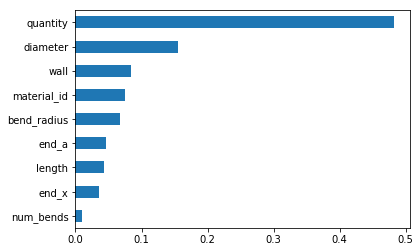

In [31]:
feature_importances = pd.Series(model.feature_importances_, features)
feature_importances.sort_values().plot.barh();

#Hyper Param/ CV

In [49]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

features = ['quantity', 'length', 'num_bends',
            'bend_radius', 'diameter', 'end_a',
            'end_x', 'material_id', 'wall']
target = 'cost'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
y_train_log = np.log1p(y_train)

groups = train['tube_assembly_id']

pipeline = make_pipeline(
    OrdinalEncoder(),
    XGBRegressor(random_state=47)
)

param_distributions = {
    'xgbregressor__n_estimators': [x for x in range(450, 500, 1)]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 5,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    verbose=10,
    return_train_score = True,
    n_jobs = -1
)


search.fit(X_train, y_train_log, groups=groups);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:58:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [50]:
print(f'Best Hyperparameters: {search.best_params_}')
print(f'Cross_validation RMSLE: {np.sqrt(-search.best_score_)}')

Best Hyperparameters: {'xgbregressor__n_estimators': 465}
Cross_validation RMSLE: 0.49776341238222976


#Test

In [0]:
y_pred = pipe.predict(test[features])

In [27]:
test.describe()

,id,annual_usage,min_order_quantity,quantity,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,30235.000000,3.023500e+04,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000
mean,15118.000000,2.521253e+02,2.297503,37.959782,17.335842,1.375376,99.902491,3.863238,44.621570,0.025765,0.004134,0.015876
std,8728.237031,2.021673e+04,21.083151,70.365779,18.392260,0.670536,62.808473,2.206852,244.583923,0.191343,0.075531,0.148684
min,1.000000,0.000000e+00,0.000000,1.000000,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7559.500000,0.000000e+00,0.000000,2.000000,9.520000,0.890000,50.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,15118.000000,0.000000e+00,0.000000,10.000000,12.700000,1.240000,89.000000,4.000000,31.750000,0.000000,0.000000,0.000000
75%,22676.500000,2.000000e+00,0.000000,40.000000,19.050000,1.650000,137.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,30235.000000,3.498645e+06,2500.000000,2500.000000,203.200000,7.900000,600.000000,17.000000,9999.000000,5.000000,4.000000,6.000000


In [0]:
sub = pd.DataFrame(data = {
    'id': test['id'],
    'cost': np.expm1(y_pred)
})
sub.to_csv('submission.csv', index=False)

In [0]:
sub.head()

,id,cost
0,1,13.843841
1,2,13.245848
2,3,8.338506
3,4,5.857256
4,5,4.321346
